In [2]:
# === Cell 1: Load data dan fitur terpilih ===

import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split

# Load data hasil preprocessing
X_scaled = pd.read_csv("../data/processed/X_scaled.csv", dtype="float32")
y = pd.read_csv("../data/processed/y.csv", dtype="int8").squeeze()

# Load daftar fitur terpilih
with open("../data/processed/selected_features.json") as f:
    selected_features = json.load(f)

# Ambil hanya kolom fitur terpilih
X_selected = X_scaled[selected_features]

print(f"Jumlah fitur terpilih: {len(selected_features)}")
print(f"Shape data lengkap: {X_selected.shape}")
print(f"Distribusi label: {y.value_counts().to_dict()}")


Jumlah fitur terpilih: 30
Shape data lengkap: (2768674, 30)
Distribusi label: {1: 2242880, 0: 525794}


In [4]:
# === Cell 2: Split data train/val/test ===

X_temp, X_test, y_temp, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


Train: (1771951, 30), Val: (442988, 30), Test: (553735, 30)


In [5]:
# === Cell 3: Train model LightGBM ===

from lightgbm import LGBMClassifier, early_stopping

lgbm = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42,
    n_jobs=-1
)

lgbm.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="binary_logloss",
    callbacks=[early_stopping(stopping_rounds=50, verbose=True)]
)

print("✅ Training selesai")


[LightGBM] [Info] Number of positive: 1435443, number of negative: 336508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.122106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6512
[LightGBM] [Info] Number of data points in the train set: 1771951, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.810092 -> initscore=1.450607
[LightGBM] [Info] Start training from score 1.450607
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[320]	valid_0's binary_logloss: 0.0011987
✅ Training selesai


In [6]:
# === Cell 4: Evaluasi dasar ===

from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


ROC-AUC: 0.9999843791535619

Classification Report:
               precision    recall  f1-score   support

           0     0.9986    0.9995    0.9990    105159
           1     0.9999    0.9997    0.9998    448576

    accuracy                         0.9996    553735
   macro avg     0.9992    0.9996    0.9994    553735
weighted avg     0.9996    0.9996    0.9996    553735


Confusion Matrix:
 [[105102     57]
 [   150 448426]]


In [7]:
# === SWAP LABELS FOR DISPLAY ONLY ===

# Swap labels
y_test_swapped = 1 - y_test
y_pred_swapped = 1 - y_pred
y_prob_swapped = 1 - y_prob

print("ROC-AUC (swapped):", roc_auc_score(y_test_swapped, y_prob_swapped))

print("\nClassification Report (swapped):\n",
      classification_report(
          y_test_swapped,
          y_pred_swapped,
          digits=4,
          target_names=["0 (Benign)", "1 (Attack)"]
      ))

print("\nConfusion Matrix (swapped):\n",
      confusion_matrix(y_test_swapped, y_pred_swapped))


ROC-AUC (swapped): 0.9999843791535616

Classification Report (swapped):
               precision    recall  f1-score   support

  0 (Benign)     0.9999    0.9997    0.9998    448576
  1 (Attack)     0.9986    0.9995    0.9990    105159

    accuracy                         0.9996    553735
   macro avg     0.9992    0.9996    0.9994    553735
weighted avg     0.9996    0.9996    0.9996    553735


Confusion Matrix (swapped):
 [[448426    150]
 [    57 105102]]


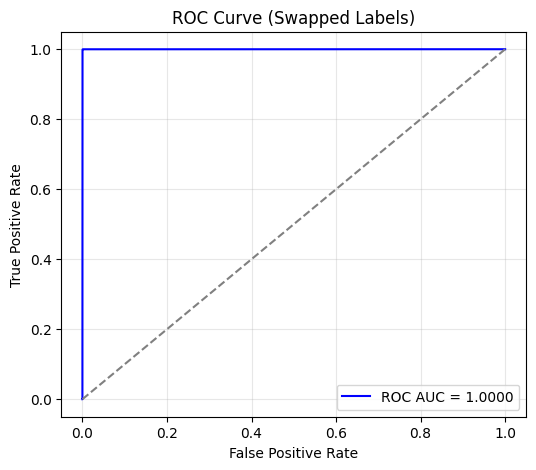

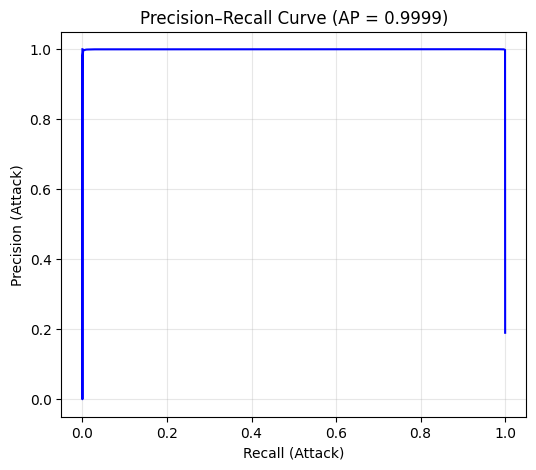

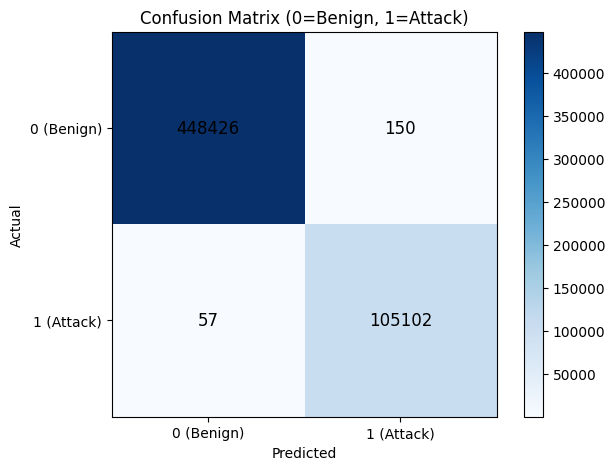

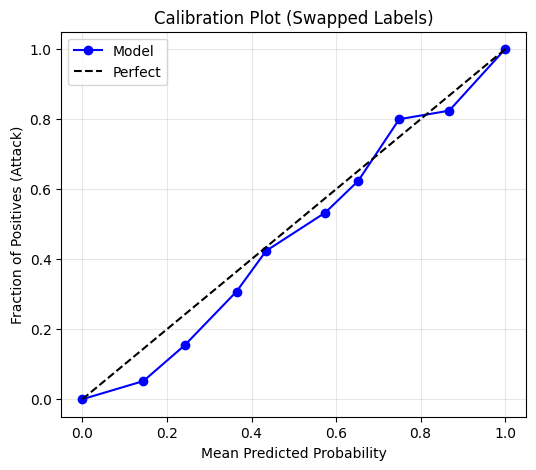

In [8]:
# === Grafik Evaluasi dengan Label Swap (0=Benign, 1=Attack) ===

import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc,
    precision_recall_curve, average_precision_score,
    confusion_matrix
)
from sklearn.calibration import calibration_curve
import numpy as np

# === Swap label SETIAP output yang dipakai untuk evaluasi ===
y_test_swapped = 1 - y_test
y_pred_swapped = 1 - y_pred
y_prob_swapped = 1 - y_prob

# ---------------- ROC Curve ----------------
fpr, tpr, _ = roc_curve(y_test_swapped, y_prob_swapped)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.title("ROC Curve (Swapped Labels)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---------------- Precision–Recall Curve ----------------
precision, recall, _ = precision_recall_curve(y_test_swapped, y_prob_swapped)
ap = average_precision_score(y_test_swapped, y_prob_swapped)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color="blue")
plt.title(f"Precision–Recall Curve (AP = {ap:.4f})")
plt.xlabel("Recall (Attack)")
plt.ylabel("Precision (Attack)")
plt.grid(alpha=0.3)
plt.show()

# ---------------- Confusion Matrix (Blue–White) ----------------
cm = confusion_matrix(y_test_swapped, y_pred_swapped)

plt.figure(figsize=(7,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix (0=Benign, 1=Attack)")
plt.colorbar()

# Labeling
classes = ["0 (Benign)", "1 (Attack)"]
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Tulisan angka
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j],
                 ha="center", va="center",
                 color="black", fontsize=12)

plt.show()

# ---------------- Calibration Plot ----------------
prob_true, prob_pred = calibration_curve(y_test_swapped, y_prob_swapped, n_bins=10)

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', color='blue', label="Model")
plt.plot([0,1], [0,1], "--", color="black", label="Perfect")
plt.title("Calibration Plot (Swapped Labels)")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives (Attack)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [5]:
import tensorflow as tf
print(tf.__version__)


2.20.0


# Distillation Update

In [68]:
# FULL DISTILLATION PIPELINE (TensorFlow Keras)
# - Combined distillation + hard-label loss
# - Deterministic seeds & single-thread guidance
# - TF Dataset pipeline
# - Metrics, best-threshold search (Youden & F1), calibration hint

import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, confusion_matrix, classification_report, roc_curve
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
import joblib

In [76]:
import os, random, numpy as np, tensorflow as tf

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()


In [ ]:
teacher_probs_train = lgbm.predict_proba(X_train)[:,1].astype("float32")
teacher_probs_val   = lgbm.predict_proba(X_val)[:,1].astype("float32")
teacher_probs_test  = lgbm.predict_proba(X_test)[:,1].astype("float32")

X_train_np = X_train.astype("float32").to_numpy()
X_val_np   = X_val.astype("float32").to_numpy()
X_test_np  = X_test.astype("float32").to_numpy()

y_train_np = y_train.astype("float32").to_numpy()
y_val_np   = y_val.astype("float32").to_numpy()
y_test_np  = y_test.astype("float32").to_numpy()


In [78]:
alpha = 0.9   # 90% ikut teacher

T = 2.5
t_train = teacher_probs_train ** (1/T)
t_val   = teacher_probs_val   ** (1/T)

y_train_distill = alpha * t_train + (1 - alpha) * y_train_np
y_val_distill   = alpha * t_val   + (1 - alpha) * y_val_np


In [79]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout

initializer = tf.keras.initializers.GlorotUniform(seed=SEED)

student = Sequential([
    Dense(256, activation='relu', kernel_initializer=initializer),
    Dropout(0.1, seed=SEED),

    Dense(128, activation='relu', kernel_initializer=initializer),
    Dropout(0.1, seed=SEED),

    Dense(64, activation='relu', kernel_initializer=initializer),
    Dense(1, activation='sigmoid', kernel_initializer=initializer)
])

student.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='binary_crossentropy',
    metrics=['AUC']
)


In [80]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=8,
        restore_best_weights=True, verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=4, verbose=1
    ),
]

history = student.fit(
    X_train_np, y_train_distill,
    validation_data=(X_val_np, y_val_distill),
    epochs=50,
    batch_size=4096,
    verbose=2,
    shuffle=True
)


Epoch 1/50
433/433 - 19s - 44ms/step - AUC: 0.0000e+00 - loss: 174.2989 - val_AUC: 0.0000e+00 - val_loss: 27.8051
Epoch 2/50
433/433 - 10s - 22ms/step - AUC: 0.0000e+00 - loss: 11.6654 - val_AUC: 0.0000e+00 - val_loss: 4.9470
Epoch 3/50
433/433 - 10s - 22ms/step - AUC: 0.0000e+00 - loss: 7.8395 - val_AUC: 0.0000e+00 - val_loss: 12.5463
Epoch 4/50
433/433 - 14s - 31ms/step - AUC: 0.0000e+00 - loss: 5.2715 - val_AUC: 0.0000e+00 - val_loss: 0.3520
Epoch 5/50
433/433 - 17s - 39ms/step - AUC: 0.0000e+00 - loss: 3.7218 - val_AUC: 0.0000e+00 - val_loss: 3.9753
Epoch 6/50
433/433 - 18s - 40ms/step - AUC: 0.0000e+00 - loss: 3.0141 - val_AUC: 0.0000e+00 - val_loss: 1.0760
Epoch 7/50
433/433 - 14s - 32ms/step - AUC: 0.0000e+00 - loss: 2.4640 - val_AUC: 0.0000e+00 - val_loss: 2.2025
Epoch 8/50
433/433 - 13s - 30ms/step - AUC: 0.0000e+00 - loss: 1.6849 - val_AUC: 0.0000e+00 - val_loss: 0.5304
Epoch 9/50
433/433 - 14s - 33ms/step - AUC: 0.0000e+00 - loss: 0.6052 - val_AUC: 0.0000e+00 - val_loss: 0.2

In [81]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

y_prob = student.predict(X_test_np, batch_size=4096).squeeze()
y_pred = (y_prob > 0.5).astype(int)

print("ROC-AUC:", roc_auc_score(y_test_np, y_prob))
print("\nReport:\n", classification_report(y_test_np, y_pred))
print("\nCM:\n", confusion_matrix(y_test_np, y_pred))


136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
ROC-AUC: 0.9895105680214477

Report:
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    105159
           1       0.98      1.00      0.99    448576

    accuracy                           0.98    553735
   macro avg       0.99      0.95      0.96    553735
weighted avg       0.98      0.98      0.98    553735


CM:
 [[ 94014  11145]
 [   397 448179]]


In [82]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Probabilitas output dari student model tetap sama
y_prob = student.predict(X_test_np, batch_size=4096).squeeze()

# === SWAP LABEL ===
# sebelumnya: prob = probabilitas benign
# sekarang:   prob_attack = 1 - prob
y_prob_swapped = 1 - y_prob

# label prediksi baru
y_pred_swapped = (y_prob_swapped > 0.5).astype(int)

# y_test sebelumnya (0=attack, 1=benign)
# sekarang ingin (0=benign, 1=attack)
y_test_swapped = 1 - y_test_np

print("ROC-AUC:", roc_auc_score(y_test_swapped, y_prob_swapped))
print("\nReport:\n", classification_report(y_test_swapped, y_pred_swapped))
print("\nCM:\n", confusion_matrix(y_test_swapped, y_pred_swapped))


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
ROC-AUC: 0.9895105677034609

Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99    448576
           1       1.00      0.89      0.94    105159

    accuracy                           0.98    553735
   macro avg       0.99      0.95      0.96    553735
weighted avg       0.98      0.98      0.98    553735


CM:
 [[448179    397]
 [ 11145  94014]]


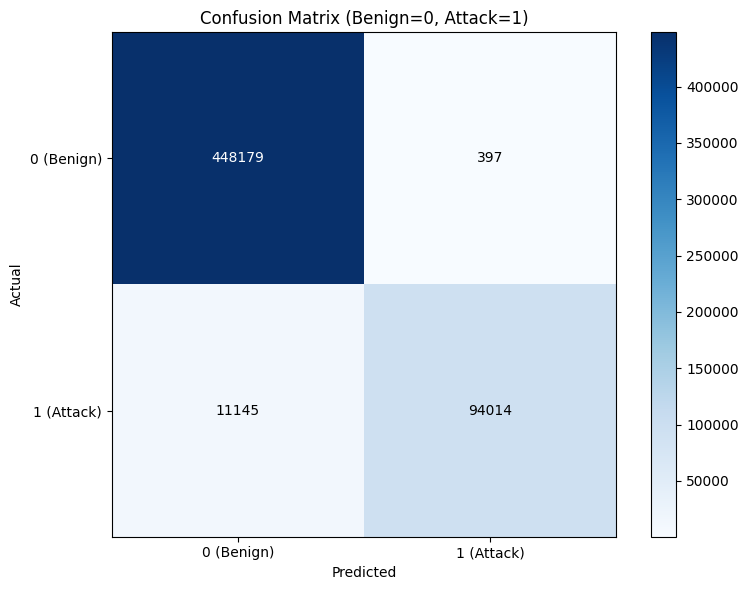

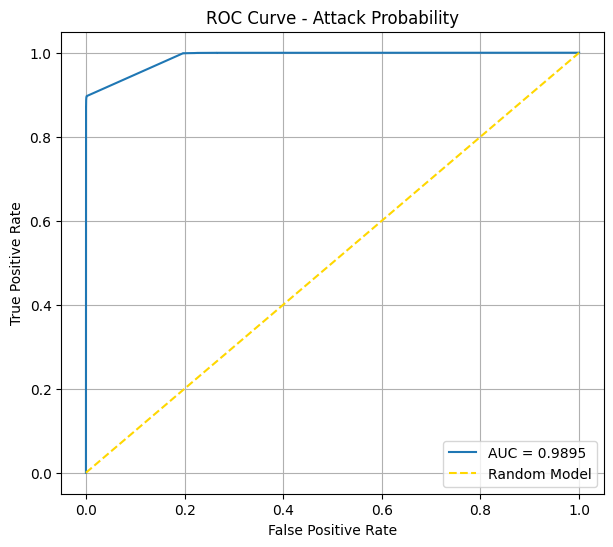

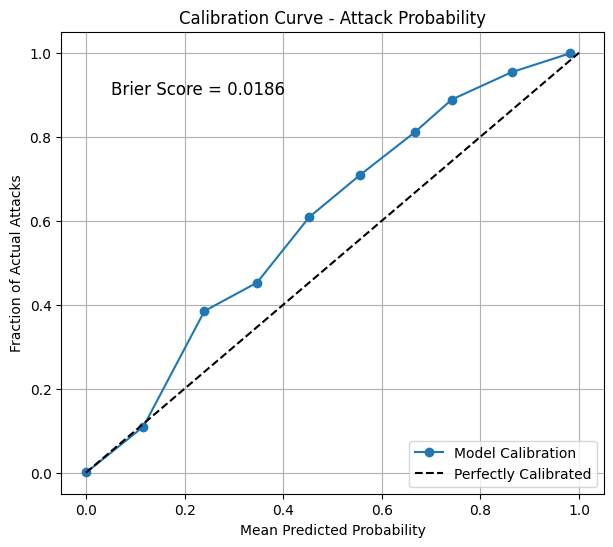

C:\Users\BINTANG PANDU\AppData\Local\Temp\ipykernel_26092\1704748882.py:79: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  ap = np.trapz(precision, recall)


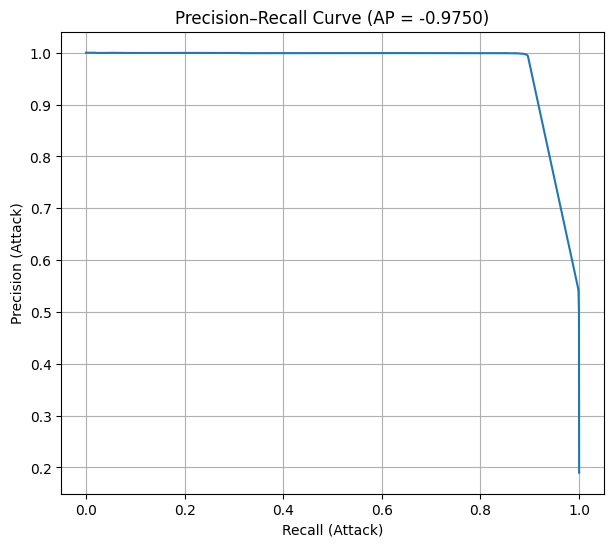

Best Threshold (Youden): 0.1439057


In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, classification_report,
    brier_score_loss, precision_recall_curve
)
from sklearn.calibration import calibration_curve

# -------------------------------------------------------------
# 1) Confusion Matrix (Benign=0, Attack=1) — Style sama seperti gambar kamu
# -------------------------------------------------------------
cm = confusion_matrix(y_test_swapped, y_pred_swapped)

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, cmap="Blues")

ax.figure.colorbar(im, ax=ax)

ax.set(
    xticks=np.arange(2),
    yticks=np.arange(2),
    xticklabels=["0 (Benign)", "1 (Attack)"],
    yticklabels=["0 (Benign)", "1 (Attack)"],
    ylabel="Actual",
    xlabel="Predicted",
    title="Confusion Matrix (Benign=0, Attack=1)"
)

# write numbers inside matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], "d"),
                ha="center", va="center",
                color="black" if cm[i, j] < cm.max()/1.5 else "white")

plt.tight_layout()
plt.show()

# -------------------------------------------------------------
# 2) ROC Curve (prob_attack)
# -------------------------------------------------------------
fpr, tpr, thresholds = roc_curve(y_test_swapped, y_prob_swapped)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gold", label="Random Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Attack Probability")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# 3) Calibration Curve
# -------------------------------------------------------------
frac_pos, mean_pred = calibration_curve(y_test_swapped, y_prob_swapped, n_bins=10)

brier = brier_score_loss(y_test_swapped, y_prob_swapped)

plt.figure(figsize=(7,6))
plt.plot(mean_pred, frac_pos, "o-", label="Model Calibration")
plt.plot([0,1], [0,1], "k--", label="Perfectly Calibrated")

plt.title("Calibration Curve - Attack Probability")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Actual Attacks")
plt.text(0.05, 0.9, f"Brier Score = {brier:.4f}", fontsize=12)

plt.legend()
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# 4) Precision-Recall Curve
# -------------------------------------------------------------
precision, recall, pr_thresh = precision_recall_curve(y_test_swapped, y_prob_swapped)
ap = np.trapz(precision, recall)

plt.figure(figsize=(7, 6))
plt.plot(recall, precision)
plt.xlabel("Recall (Attack)")
plt.ylabel("Precision (Attack)")
plt.title(f"Precision–Recall Curve (AP = {ap:.4f})")
plt.grid(True)
plt.show()

# -------------------------------------------------------------
# 5) Best Threshold (Youden J)
# -------------------------------------------------------------
youden_J = tpr - fpr
best_idx = np.argmax(youden_J)
best_threshold = thresholds[best_idx]

print("Best Threshold (Youden):", best_threshold)


In [88]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test_np, y_prob)

# Youden index
youden = tpr - fpr
best_idx = np.argmax(youden)
best_threshold = thresholds[best_idx]

print("Best Threshold (Youden):", best_threshold)
print("Youden J:", youden[best_idx])


Best Threshold (Youden): 0.85612047
Youden J: 0.8950649117287734


In [89]:
import tensorflow as tf

# Path model Keras (.keras atau .h5)
MODEL_PATH = "student_best.keras"
TFLITE_PATH = "student7.tflite"

# Jika model belum dimuat, muat dulu
model = tf.keras.models.load_model(MODEL_PATH)

# Converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan
with open(TFLITE_PATH, "wb") as f:
    f.write(tflite_model)

print("Saved TFLite (FP32) to", TFLITE_PATH)


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmprt4wj2s4\assets


INFO:tensorflow:Assets written to: C:\Users\BINTAN~1\AppData\Local\Temp\tmprt4wj2s4\assets


Saved artifact at 'C:\Users\BINTAN~1\AppData\Local\Temp\tmprt4wj2s4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 30), dtype=tf.float32, name='input_layer_5')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  2826019440016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2823342551504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2825635085008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2825635082896: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2825635083280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2825635070992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2825635071184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2825635073680: TensorSpec(shape=(), dtype=tf.resource, name=None)
Saved TFLite (FP32) to student7.tflite


In [90]:
print("TFLite size:", len(tflite_model))


TFLite size: 59828


In [86]:
y_pred_best = (y_prob > best_threshold).astype(int)

print("\n=== Evaluasi dengan Threshold Optimal (Youden) ===")
print("\nReport:\n", classification_report(y_test_np, y_pred_best))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_np, y_pred_best))



=== Evaluasi dengan Threshold Optimal (Youden) ===

Report:
               precision    recall  f1-score   support

           0       0.99      0.90      0.94    105159
           1       0.98      1.00      0.99    448576

    accuracy                           0.98    553735
   macro avg       0.98      0.95      0.96    553735
weighted avg       0.98      0.98      0.98    553735


Confusion Matrix:
 [[ 94303  10856]
 [   764 447812]]
